
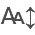

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

# import urllib.request
import fastobo

import json

import goatools
from goatools.obo_parser import GODag

import itables.options as opt
from itables import init_notebook_mode, show
from itables.downsample import as_nbytes, nbytes
from itables.sample_dfs import get_indicators

init_notebook_mode(all_interactive=True)
opt.maxBytes = "128KB"

In [ ]:
from ing_theme_matplotlib import mpl_style
mpl_style(dark=True)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.titlesize'] = 20

### Para romper las bolas:

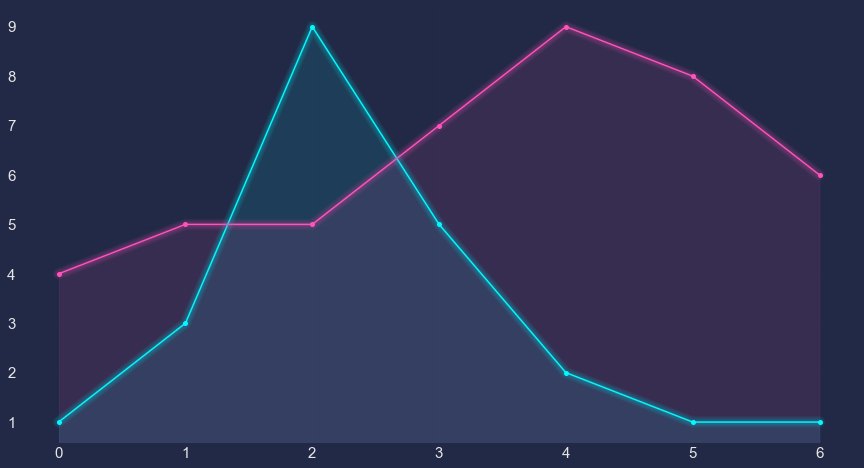

In [143]:
import mplcyberpunk
plt.style.use("cyberpunk")

def plot():
  
     
  plt.plot([1, 3, 9, 5, 2, 1, 1], marker='o')
  plt.plot([4, 5, 5, 7, 9, 8, 6], marker='o')
 
  mplcyberpunk.add_glow_effects()
  plt.show()
 
plot()

## Abro datos:

### **Datos de proteinas en Yeast**

Columns are:

1. **DB** - database contributing the file (always "SGD" for this file)

2. **DB_Object_ID** - SGDID
3. **DB_Object_Symbol** - When a Standard Gene Name (e.g. CDC28, COX2) has been conferred, it will be present in Column 3. When no Gene Name has been conferred, the Systematic Name (e.g. YAL001C, YGR116W, YAL034W-A) will be present in column 3.

4. **NOT** (optional) - 'NOT', 'contributes_to', or 'colocalizes_with' qualifier for a GO annotation, when needed
5. **GO ID** - unique numeric identifier for the GO term
6. **DB:Reference(|DB:Reference)** - the reference associated with the GO annotation
7. **Evidence** - the evidence code for the GO annotation
8. **With (or) From** (optional) - any With or From qualifier for the GO annotation
9. **Aspect** - which ontology the GO term belongs in
10. **DB_Object_Name(|Name)** (optional) - a name for the gene product in words, e.g. 'acid phosphatase'
11. **DB_Object_Synonym(|Synonym)** (optional) - The Systematic Name (e.g. YAL001C, YGR116W, YAL034W-A, Q0010) will be the first name present in Column 11. Any other names (except the Standard Name, which will be in Column 3 if	one exists), including Aliases used for the gene will also be present in this column.

12. **DB_Object_Type** - type of object annotated, e.g. gene, protein, etc.
13. **taxon(|taxon)** - taxonomic identifier of species encoding gene product
14. **Date** - date GO annotation was made
15. **Assigned_by** - source of the annotation (e.g. SGD, UniProtKB, YeastFunc, bioPIXIE_MEFIT)

In [45]:
gaf_df = pd.read_csv('../../Datos/gene_association.sgd.20241028.gaf', sep='\t', comment='!', header=None, low_memory=False)
short_headers = ["DB", "SGDID", "Symbol", "Qualifier", "GO_ID", "Reference", "Evidence", 
	"With_From", "Aspect", "Name", "Synonym", "Type", "Taxon", "Date", "Assigned_by1", "Assigned_by2", "Assigned_by3"]

gaf_df.columns = short_headers
gaf_df.head()

DB       SGDID Symbol                   Qualifier       GO_ID  \
0  SGD  S000003381   GPC1  acts_upstream_of_or_within  GO:0090640   
1  SGD  S000005701   ALE1  acts_upstream_of_or_within  GO:0090640   
2  SGD  S000003381   GPC1  acts_upstream_of_or_within  GO:0036151   
3  SGD  S000004492   RCF1  acts_upstream_of_or_within  GO:0033617   
4  SGD  S000004977  SIW14                     enables  GO:0052845   

       Reference Evidence       With_From Aspect  \
0  PMID:30514764      IGI  SGD:S000005701      P   
1  PMID:30514764      IGI  SGD:S000003381      P   
2  PMID:30514764      IMP             NaN      P   
3  PMID:29746825      IMP             NaN      P   
4  PMID:26828065      IDA             NaN      F   

                                                Name  \
0      Glycerophosphocholine acyltransferase (GPCAT)   
1  Broad-specificity lysophospholipid acyltransfe...   
2      Glycerophosphocholine acyltransferase (GPCAT)   
3                       Cytochrome c oxidase subunit   
4  Inositol phosphatase involved in inositol pyro...   

                                             Synonym     Type         Taxon  \
0      YGR149W|glycerophosphocholine acyltransferase  protein  taxon:559292   
1  YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein  taxon:559292   
2      YGR149W|glycerophosphocholine acyltransferase  protein  taxon:559292   
3                                      YML030W|AIM31  protein  taxon:559292   
4  YNL032W|OCA3|putative tyrosine protein phospha...  protein  taxon:559292   

       Date Assigned_by1         Assigned_by2      Assigned_by3  
0  20181220          SGD                  NaN  UniProtKB:P48236  
1  20181220          SGD                  NaN  UniProtKB:Q08548  
2  20181220          SGD                  NaN  UniProtKB:P48236  
3  20181212          SGD                  NaN  UniProtKB:Q03713  
4  20190110          SGD  part_of(GO:0071543)  UniProtKB:P53965

In [4]:
# Tomo solo las columnas que me interesan:

df_proteinas = gaf_df[["SGDID", "Qualifier", "GO_ID", "With_From", "Synonym", "Type",  "Date"]].copy()
df_proteinas['Date'] = pd.to_datetime(df_proteinas['Date'], format='%Y%m%d')
df_proteinas

SGDID                   Qualifier       GO_ID       With_From  \
0       S000003381  acts_upstream_of_or_within  GO:0090640  SGD:S000005701   
1       S000005701  acts_upstream_of_or_within  GO:0090640  SGD:S000003381   
2       S000003381  acts_upstream_of_or_within  GO:0036151             NaN   
3       S000004492  acts_upstream_of_or_within  GO:0033617             NaN   
4       S000004977                     enables  GO:0052845             NaN   
...            ...                         ...         ...             ...   
206943  S000006502                  located_in  GO:0005730    Rfam:RF01265   
206944  S000007313                  located_in  GO:0005730    Rfam:RF01184   
206945  S000007300                  located_in  GO:0005730    Rfam:RF01242   
206946  S000006484                  located_in  GO:0005840    Rfam:RF02543   
206947  S000006485                  located_in  GO:0005840    Rfam:RF02543   

                                                  Synonym     Type       Date  
0           YGR149W|glycerophosphocholine acyltransferase  protein 2018-12-20  
1       YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein 2018-12-20  
2           YGR149W|glycerophosphocholine acyltransferase  protein 2018-12-20  
3                                           YML030W|AIM31  protein 2018-12-12  
4       YNL032W|OCA3|putative tyrosine protein phospha...  protein 2019-01-10  
...                                                   ...      ...        ...  
206943                                    YNCK0020C|snR42   snoRNA 2024-10-14  
206944                                 YNCL0005C|Z9|snR79   snoRNA 2024-10-14  
206945                                    YNCO0022C|snR36   snoRNA 2024-10-14  
206946         YNCL0012C|25S ribosomal RNA|26S rRNA|RDN25     rRNA 2024-10-14  
206947         YNCL0021C|25S ribosomal RNA|26S rRNA|RDN25     rRNA 2024-10-14  

[206948 rows x 7 columns]

In [5]:
nombre_sistematico1 = df_proteinas['Synonym'].str.split('|').str[0]

# nombre_sistematico2 = df_proteinas['Synonym'].str.split('|').str[1]
df_proteinas['Nombre'] = nombre_sistematico1
# df_proteinas['Nombre2'] = nombre_sistematico2
df_proteinas['Index'] = df_proteinas.index

df_proteinas = df_proteinas[['Nombre', 'Date', 'SGDID', 'GO_ID', 'Qualifier', 'With_From', 'Synonym', 'Type' ]]
df_proteinas

Nombre       Date       SGDID       GO_ID  \
0         YGR149W 2018-12-20  S000003381  GO:0090640   
1         YOR175C 2018-12-20  S000005701  GO:0090640   
2         YGR149W 2018-12-20  S000003381  GO:0036151   
3         YML030W 2018-12-12  S000004492  GO:0033617   
4         YNL032W 2019-01-10  S000004977  GO:0052845   
...           ...        ...         ...         ...   
206943  YNCK0020C 2024-10-14  S000006502  GO:0005730   
206944  YNCL0005C 2024-10-14  S000007313  GO:0005730   
206945  YNCO0022C 2024-10-14  S000007300  GO:0005730   
206946  YNCL0012C 2024-10-14  S000006484  GO:0005840   
206947  YNCL0021C 2024-10-14  S000006485  GO:0005840   

                         Qualifier       With_From  \
0       acts_upstream_of_or_within  SGD:S000005701   
1       acts_upstream_of_or_within  SGD:S000003381   
2       acts_upstream_of_or_within             NaN   
3       acts_upstream_of_or_within             NaN   
4                          enables             NaN   
...                            ...             ...   
206943                  located_in    Rfam:RF01265   
206944                  located_in    Rfam:RF01184   
206945                  located_in    Rfam:RF01242   
206946                  located_in    Rfam:RF02543   
206947                  located_in    Rfam:RF02543   

                                                  Synonym     Type  
0           YGR149W|glycerophosphocholine acyltransferase  protein  
1       YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein  
2           YGR149W|glycerophosphocholine acyltransferase  protein  
3                                           YML030W|AIM31  protein  
4       YNL032W|OCA3|putative tyrosine protein phospha...  protein  
...                                                   ...      ...  
206943                                    YNCK0020C|snR42   snoRNA  
206944                                 YNCL0005C|Z9|snR79   snoRNA  
206945                                    YNCO0022C|snR36   snoRNA  
206946         YNCL0012C|25S ribosomal RNA|26S rRNA|RDN25     rRNA  
206947         YNCL0021C|25S ribosomal RNA|26S rRNA|RDN25     rRNA  

[206948 rows x 8 columns]

In [6]:
# Para ver si varia el GO_ID por experimento: Quiero buscar buscar las proteinas por 'Nombre' que se repiten y 
# quedarme con la de mayor aparicion en la base de datos, junto con esta todos los datos del dataframe

mas_repeticiones = df_proteinas['Nombre'].value_counts().idxmax()
max_prote = df_proteinas[df_proteinas['Nombre'] == mas_repeticiones]
max_prote

Nombre       Date       SGDID       GO_ID  \
4574    YPL155C 2023-05-03  S000006076  GO:0015631   
4575    YPL155C 2023-05-03  S000006076  GO:0007026   
4579    YPL155C 2023-05-03  S000006076  GO:0061863   
4580    YPL155C 2023-05-03  S000006076  GO:0061863   
4581    YPL155C 2023-05-03  S000006076  GO:0046785   
...         ...        ...         ...         ...   
135179  YPL155C 2024-09-19  S000006076  GO:0005737   
135180  YPL155C 2024-09-19  S000006076  GO:0005737   
135181  YPL155C 2024-09-19  S000006076  GO:0005737   
181784  YPL155C 2024-10-14  S000006076  GO:0005524   
181785  YPL155C 2024-10-14  S000006076  GO:0051301   

                         Qualifier               With_From  Synonym     Type  
4574                       enables                     NaN  YPL155C  protein  
4575    acts_upstream_of_or_within                     NaN  YPL155C  protein  
4579                       enables                     NaN  YPL155C  protein  
4580                       enables                     NaN  YPL155C  protein  
4581                   involved_in                     NaN  YPL155C  protein  
...                            ...                     ...      ...      ...  
135179                is_active_in  dictyBase:DDB_G0280967  YPL155C  protein  
135180                is_active_in  dictyBase:DDB_G0281555  YPL155C  protein  
135181                is_active_in  dictyBase:DDB_G0284471  YPL155C  protein  
181784                     enables    UniProtKB-KW:KW-0067  YPL155C  protein  
181785                 involved_in    UniProtKB-KW:KW-0132  YPL155C  protein  

[311 rows x 8 columns]

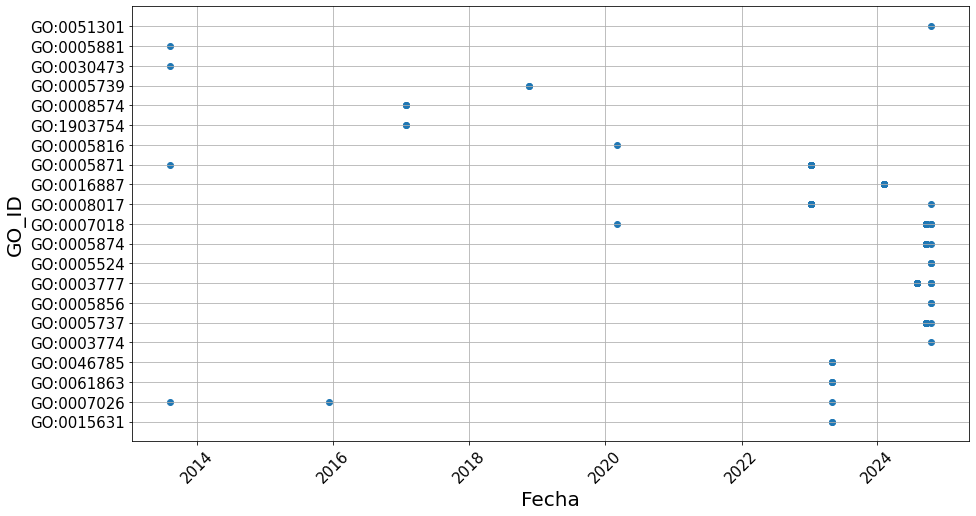

In [7]:
plt.scatter(max_prote['Date'], max_prote['GO_ID'], label = 'GO_ID')
plt.xlabel('Fecha')
plt.ylabel('GO_ID')

plt.grid(True)
# plt.legend()

plt.xticks(rotation = 45);

In [8]:
# De aca se puede ver que para una misma fecha se le puede asignar distintos GO_ID a una misma proteina, o iguales pero con alguna otra propiedad distinta que estoy ignorando.
max_prote[max_prote['Date'] == max_prote['Date'].max()] 

Nombre       Date       SGDID       GO_ID    Qualifier  \
33543   YPL155C 2024-10-14  S000006076  GO:0003774      enables   
50391   YPL155C 2024-10-14  S000006076  GO:0005737   located_in   
50394   YPL155C 2024-10-14  S000006076  GO:0005856   located_in   
50395   YPL155C 2024-10-14  S000006076  GO:0005856   located_in   
86526   YPL155C 2024-10-14  S000006076  GO:0005524      enables   
86527   YPL155C 2024-10-14  S000006076  GO:0005524      enables   
86818   YPL155C 2024-10-14  S000006076  GO:0005874   located_in   
109893  YPL155C 2024-10-14  S000006076  GO:0003777      enables   
109894  YPL155C 2024-10-14  S000006076  GO:0003777      enables   
109895  YPL155C 2024-10-14  S000006076  GO:0003777      enables   
109896  YPL155C 2024-10-14  S000006076  GO:0008017      enables   
135120  YPL155C 2024-10-14  S000006076  GO:0007018  involved_in   
135121  YPL155C 2024-10-14  S000006076  GO:0007018  involved_in   
135122  YPL155C 2024-10-14  S000006076  GO:0007018  involved_in   
181784  YPL155C 2024-10-14  S000006076  GO:0005524      enables   
181785  YPL155C 2024-10-14  S000006076  GO:0051301  involved_in   

                        With_From  Synonym     Type  
33543                         NaN  YPL155C  protein  
50391        UniProtKB-KW:KW-0963  YPL155C  protein  
50394        UniProtKB-KW:KW-0206  YPL155C  protein  
50395   UniProtKB-SubCell:SL-0090  YPL155C  protein  
86526          InterPro:IPR001752  YPL155C  protein  
86527          InterPro:IPR019821  YPL155C  protein  
86818        UniProtKB-KW:KW-0493  YPL155C  protein  
109893         InterPro:IPR001752  YPL155C  protein  
109894         InterPro:IPR019821  YPL155C  protein  
109895         InterPro:IPR027640  YPL155C  protein  
109896         InterPro:IPR001752  YPL155C  protein  
135120         InterPro:IPR001752  YPL155C  protein  
135121         InterPro:IPR019821  YPL155C  protein  
135122         InterPro:IPR027640  YPL155C  protein  
181784       UniProtKB-KW:KW-0067  YPL155C  protein  
181785       UniProtKB-KW:KW-0132  YPL155C  protein

In [9]:
# df_proteinas.groupby('GO_ID').count().sort_values('Nombre', ascending = False)

### Datos de GeneOntology:

#### Este tiene otra info que no se que es

In [150]:
# Cargar el archivo JSON
with open('../../Datos/go_yeast.json') as f:
    data = json.load(f)

In [153]:
print(len(data), data['graphs'][0].keys())

1 dict_keys(['id', 'meta', 'nodes', 'edges', 'logicalDefinitionAxioms', 'propertyChainAxioms'])


In [169]:
data #Quiero armar de esto un dataframe con las columnas del GO_ID y demas informacion relevante

{'graphs': [{'id': 'http://purl.obolibrary.org/obo/go/subsets/goslim_yeast.owl',
   'meta': {'basicPropertyValues': [{'pred': 'http://www.w3.org/2002/07/owl#versionInfo',
      'val': '2024-09-08'}],
    'version': 'http://purl.obolibrary.org/obo/go/2024-09-08/subsets/goslim_yeast.owl'},
   'nodes': [{'id': 'http://purl.obolibrary.org/obo/BFO_0000050',
     'lbl': 'part of',
     'type': 'PROPERTY',
     'meta': {'xrefs': [{'val': 'BFO:0000050'}],
      'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
        'val': 'external'},
       {'pred': 'http://www.geneontology.org/formats/oboInOwl#shorthand',
        'val': 'part_of'}]}},
    {'id': 'http://purl.obolibrary.org/obo/BFO_0000051',
     'lbl': 'has part',
     'type': 'PROPERTY',
     'meta': {'xrefs': [{'val': 'BFO:0000051'}],
      'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
        'val': 'external'},
       {'pred': 'http://www

In [178]:
data['graphs'][0].keys()

dict_keys(['id', 'meta', 'nodes', 'edges', 'logicalDefinitionAxioms', 'propertyChainAxioms'])

In [ ]:
data['graphs'][0]['id'] #Me dice de donde lo descargo NO ME INTERESA

'http://purl.obolibrary.org/obo/go/subsets/goslim_yeast.owl'

In [ ]:
data['graphs'][0]['meta'] #Me dice la version de la ontologia NO ME INTERESA

{'basicPropertyValues': [{'pred': 'http://www.w3.org/2002/07/owl#versionInfo',
   'val': '2024-09-08'}],
 'version': 'http://purl.obolibrary.org/obo/go/2024-09-08/subsets/goslim_yeast.owl'}

In [ ]:
data['graphs'][0]['nodes'][:2] #Recortado para visualizar mejor. Lista, nodos de la ontologia, ESTO ME INTERESA

[{'id': 'http://purl.obolibrary.org/obo/BFO_0000050',
  'lbl': 'part of',
  'type': 'PROPERTY',
  'meta': {'xrefs': [{'val': 'BFO:0000050'}],
   'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
     'val': 'external'},
    {'pred': 'http://www.geneontology.org/formats/oboInOwl#shorthand',
     'val': 'part_of'}]}},
 {'id': 'http://purl.obolibrary.org/obo/BFO_0000051',
  'lbl': 'has part',
  'type': 'PROPERTY',
  'meta': {'xrefs': [{'val': 'BFO:0000051'}],
   'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
     'val': 'external'},
    {'pred': 'http://www.geneontology.org/formats/oboInOwl#shorthand',
     'val': 'has_part'}]}}]

In [217]:
lista_GO = data['graphs'][0]['nodes']
lista_GO[10], lista_GO[10].keys() #Veo que informacion tiene cada nodo

({'id': 'http://purl.obolibrary.org/obo/GO_0000054',
  'lbl': 'ribosomal subunit export from nucleus',
  'type': 'CLASS',
  'meta': {'definition': {'val': 'The directed movement of a ribosomal subunit from the nucleus into the cytoplasm.',
    'xrefs': ['GOC:ai']},
   'subsets': ['http://purl.obolibrary.org/obo/go#goslim_yeast'],
   'synonyms': [{'pred': 'hasExactSynonym',
     'val': 'ribosomal subunit export from cell nucleus',
     'xrefs': ['GOC:mah']},
    {'pred': 'hasExactSynonym',
     'val': 'ribosomal subunit export out of nucleus',
     'xrefs': ['GOC:mah']},
    {'pred': 'hasExactSynonym',
     'val': 'ribosomal subunit transport from nucleus to cytoplasm',
     'xrefs': ['GOC:mah']},
    {'pred': 'hasExactSynonym',
     'val': 'ribosomal subunit-nucleus export',
     'xrefs': ['GOC:mah']},
    {'pred': 'hasRelatedSynonym',
     'val': 'ribosome export from nucleus',
     'xrefs': ['GOC:mah', 'GOC:rb']}],
   'basicPropertyValues': [{'pred': 'http://www.geneontology.org/form

In [ ]:
# Quiero tomar el nombre de la ontologia y el GO_ID

GO_ID = []
name = []
go_url = []

for i in range(len(lista_GO)):
	
	try:
		go_url.append(lista_GO[i]['id'])
		GO_ID.append(lista_GO[i]['id'].split('/')[-1].replace('_', ':'))	
		name.append(lista_GO[i]['lbl'])
	except:
		print(i)
		# pass

df_GO = pd.DataFrame({'GO_ID': GO_ID, 'Name': name, 'URL': go_url})
df_GO

GO_ID                 Name  \
0                   BFO:0000050              part of   
1                   BFO:0000051             has part   
2                   BFO:0000062          preceded by   
3                   BFO:0000063             precedes   
4                   BFO:0000066            occurs in   
..                          ...                  ...   
270  oboInOwl#hasRelatedSynonym  has_related_synonym   
271           oboInOwl#hasScope            has_scope   
272     oboInOwl#hasSynonymType     has_synonym_type   
273           oboInOwl#inSubset            in_subset   
274          oboInOwl#shorthand            shorthand   

                                                   URL  
0           http://purl.obolibrary.org/obo/BFO_0000050  
1           http://purl.obolibrary.org/obo/BFO_0000051  
2           http://purl.obolibrary.org/obo/BFO_0000062  
3           http://purl.obolibrary.org/obo/BFO_0000063  
4           http://purl.obolibrary.org/obo/BFO_0000066  
..                                                 ...  
270  http://www.geneontology.org/formats/oboInOwl#h...  
271  http://www.geneontology.org/formats/oboInOwl#h...  
272  http://www.geneontology.org/formats/oboInOwl#h...  
273  http://www.geneontology.org/formats/oboInOwl#i...  
274  http://www.geneontology.org/formats/oboInOwl#s...  

[275 rows x 3 columns]

In [227]:
# data['graphs'][0]['edges'] #Recortado para visualizar mejor. Lista, aristas de la ontologia, NO ME INTERESA

#### Me quedo con el .obo asi mapeo directo de GO a BP, CC, MF

In [11]:
go_dag = GODag("../../Datos/go_yeast.obo")

../../Datos/go_yeast.obo: fmt(1.2) rel(go/2024-09-08/subsets/goslim_yeast.owl) 296 Terms


In [12]:
go_to_namespace = {go_id: go_dag[go_id].namespace for go_id in go_dag}
go_to_namespace

{'GO:0000054': 'biological_process',
 'GO:0000278': 'biological_process',
 'GO:0000747': 'biological_process',
 'GO:0000902': 'biological_process',
 'GO:0000910': 'biological_process',
 'GO:0001403': 'biological_process',
 'GO:0002181': 'biological_process',
 'GO:0003674': 'molecular_function',
 'GO:0003677': 'molecular_function',
 'GO:0003682': 'molecular_function',
 'GO:0003700': 'molecular_function',
 'GO:0003723': 'molecular_function',
 'GO:0003729': 'molecular_function',
 'GO:0003735': 'molecular_function',
 'GO:0003924': 'molecular_function',
 'GO:0004386': 'molecular_function',
 'GO:0004518': 'molecular_function',
 'GO:0005085': 'molecular_function',
 'GO:0005198': 'molecular_function',
 'GO:0005575': 'cellular_component',
 'GO:0005576': 'cellular_component',
 'GO:0005618': 'cellular_component',
 'GO:0005634': 'cellular_component',
 'GO:0005694': 'cellular_component',
 'GO:0005730': 'cellular_component',
 'GO:0005737': 'cellular_component',
 'GO:0005739': 'cellular_component',
 

### Trato de unificar ambos DF

In [13]:
df_proteinas2 = df_proteinas.copy()

df_proteinas2['Namespace'] = df_proteinas2['GO_ID'].map(go_to_namespace).fillna('vacio')



# for go in df_proteinas2['GO_ID']:
#     if go in go_to_namespace.keys():
#         df_proteinas2[df_proteinas2['GO_ID'] == go, 'Namespace'] = str(go)
#     else:
#         print(go)

df_proteinas2

Nombre       Date       SGDID       GO_ID  \
0         YGR149W 2018-12-20  S000003381  GO:0090640   
1         YOR175C 2018-12-20  S000005701  GO:0090640   
2         YGR149W 2018-12-20  S000003381  GO:0036151   
3         YML030W 2018-12-12  S000004492  GO:0033617   
4         YNL032W 2019-01-10  S000004977  GO:0052845   
...           ...        ...         ...         ...   
206943  YNCK0020C 2024-10-14  S000006502  GO:0005730   
206944  YNCL0005C 2024-10-14  S000007313  GO:0005730   
206945  YNCO0022C 2024-10-14  S000007300  GO:0005730   
206946  YNCL0012C 2024-10-14  S000006484  GO:0005840   
206947  YNCL0021C 2024-10-14  S000006485  GO:0005840   

                         Qualifier       With_From  \
0       acts_upstream_of_or_within  SGD:S000005701   
1       acts_upstream_of_or_within  SGD:S000003381   
2       acts_upstream_of_or_within             NaN   
3       acts_upstream_of_or_within             NaN   
4                          enables             NaN   
...                            ...             ...   
206943                  located_in    Rfam:RF01265   
206944                  located_in    Rfam:RF01184   
206945                  located_in    Rfam:RF01242   
206946                  located_in    Rfam:RF02543   
206947                  located_in    Rfam:RF02543   

                                                  Synonym     Type  \
0           YGR149W|glycerophosphocholine acyltransferase  protein   
1       YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein   
2           YGR149W|glycerophosphocholine acyltransferase  protein   
3                                           YML030W|AIM31  protein   
4       YNL032W|OCA3|putative tyrosine protein phospha...  protein   
...                                                   ...      ...   
206943                                    YNCK0020C|snR42   snoRNA   
206944                                 YNCL0005C|Z9|snR79   snoRNA   
206945                                    YNCO0022C|snR36   snoRNA   
206946         YNCL0012C|25S ribosomal RNA|26S rRNA|RDN25     rRNA   
206947         YNCL0021C|25S ribosomal RNA|26S rRNA|RDN25     rRNA   

                 Namespace  
0                    vacio  
1                    vacio  
2                    vacio  
3                    vacio  
4                    vacio  
...                    ...  
206943  cellular_component  
206944  cellular_component  
206945  cellular_component  
206946  cellular_component  
206947  cellular_component  

[206948 rows x 9 columns]

In [14]:
df_sobra = df_proteinas2[df_proteinas2['Namespace'] == 'vacio'].copy()
df_funciones = df_proteinas2[df_proteinas2['Namespace'] != 'vacio'].copy()

df_funciones

Nombre       Date       SGDID       GO_ID     Qualifier  \
12        YGL242C 2023-08-09  S000003211  GO:0005737  is_active_in   
16        YML074C 2020-01-27  S000004539  GO:0005634    located_in   
21        YCL011C 2020-01-27  S000000517  GO:0005634    located_in   
22        YOR051C 2020-01-27  S000005577  GO:0005634    located_in   
46        YKL020C 2018-11-02  S000001503  GO:0003674       enables   
...           ...        ...         ...         ...           ...   
206943  YNCK0020C 2024-10-14  S000006502  GO:0005730    located_in   
206944  YNCL0005C 2024-10-14  S000007313  GO:0005730    located_in   
206945  YNCO0022C 2024-10-14  S000007300  GO:0005730    located_in   
206946  YNCL0012C 2024-10-14  S000006484  GO:0005840    located_in   
206947  YNCL0021C 2024-10-14  S000006485  GO:0005840    located_in   

           With_From                                            Synonym  \
12               NaN                                            YGL242C   
16               NaN        YML074C|NPI46|peptidylprolyl isomerase FPR3   
21               NaN  YCL011C|RLF6|single-stranded telomeric DNA-bin...   
22               NaN                              YOR051C|NRO1|YOR29-02   
46               NaN                                            YKL020C   
...              ...                                                ...   
206943  Rfam:RF01265                                    YNCK0020C|snR42   
206944  Rfam:RF01184                                 YNCL0005C|Z9|snR79   
206945  Rfam:RF01242                                    YNCO0022C|snR36   
206946  Rfam:RF02543         YNCL0012C|25S ribosomal RNA|26S rRNA|RDN25   
206947  Rfam:RF02543         YNCL0021C|25S ribosomal RNA|26S rRNA|RDN25   

           Type           Namespace  
12      protein  cellular_component  
16      protein  cellular_component  
21      protein  cellular_component  
22      protein  cellular_component  
46      protein  molecular_function  
...         ...                 ...  
206943   snoRNA  cellular_component  
206944   snoRNA  cellular_component  
206945   snoRNA  cellular_component  
206946     rRNA  cellular_component  
206947     rRNA  cellular_component  

[72720 rows x 9 columns]

In [15]:
# Veo que una misma proteina tenga distintas funciones biologicas, pruebo con la segunda que mas se repite
repeticiones = df_funciones['Nombre'].value_counts()
print(df_funciones[df_funciones['Nombre'] == repeticiones.index[1]]['Namespace'])


5707      cellular_component
30739     molecular_function
30740     molecular_function
70128     cellular_component
70131     biological_process
                 ...        
178880    cellular_component
178881    cellular_component
178882    cellular_component
178883    cellular_component
178884    cellular_component
Name: Namespace, Length: 118, dtype: object


### Abro archivo de interacciones entre proteinas

In [16]:
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

In [17]:
interacciones_apms = abrir_txt('/content/yeast_AP-MS.txt')
interacciones_apms

[['YAL001C', 'YBR123C'],
 ['YAL001C', 'YDR362C'],
 ['YAL001C', 'YGR047C'],
 ['YAL001C', 'YOR110W'],
 ['YAL001C', 'YPL007C'],
 ['YAL002W', 'YLR148W'],
 ['YAL002W', 'YLR396C'],
 ['YAL002W', 'YMR231W'],
 ['YAL002W', 'YPL045W'],
 ['YAL003W', 'YEL034W'],
 ['YAL003W', 'YGR285C'],
 ['YAL003W', 'YHR064C'],
 ['YAL003W', 'YKL081W'],
 ['YAL003W', 'YLR249W'],
 ['YAL003W', 'YPL048W'],
 ['YAL007C', 'YAR002CA'],
 ['YAL007C', 'YGL200C'],
 ['YAL007C', 'YML012W'],
 ['YAL011W', 'YBR231C'],
 ['YAL011W', 'YDR190C'],
 ['YAL011W', 'YDR334W'],
 ['YAL011W', 'YDR485C'],
 ['YAL011W', 'YJL081C'],
 ['YAL011W', 'YLR085C'],
 ['YAL011W', 'YNL107W'],
 ['YAL011W', 'YPL235W'],
 ['YAL013W', 'YBR095C'],
 ['YAL013W', 'YDL076C'],
 ['YAL013W', 'YIL084C'],
 ['YAL013W', 'YMR263W'],
 ['YAL013W', 'YNL097C'],
 ['YAL013W', 'YNL330C'],
 ['YAL013W', 'YOL004W'],
 ['YAL013W', 'YPL139C'],
 ['YAL013W', 'YPL181W'],
 ['YAL016W', 'YDL134C'],
 ['YAL016W', 'YDL188C'],
 ['YAL016W', 'YGL190C'],
 ['YAL016W', 'YGR161C'],
 ['YAL016W', 'YML109W'],

In [18]:
# Voy a armar un grafo con las proteinas de df_funciones en la columna 'Nombre' y los enlaces segun dado interaccion_apms: [['YAL001C', 'YBR123C'], ['YAL001C', 'YDR362C'], ...]
# Luego voy a darles un color a cada nodo segun su Namespace

G = nx.Graph()

for i in range(len(interacciones_apms)):
    G.add_edge(interacciones_apms[i][0], interacciones_apms[i][1])
    
for node in G.nodes():
	if node in df_funciones['Nombre'].values:
		G.nodes[node]['Namespace'] = df_funciones[df_funciones['Nombre'] == node]['Namespace'].values[0]
	else:
		G.nodes[node]['Namespace'] = 'vacio'

color_map = []
for node in G:
    if G.nodes[node].get('Namespace') == 'molecular_function':
        color_map.append('#FF8C42') 
    elif G.nodes[node].get('Namespace') == 'biological_process':
        color_map.append('seagreen')
    elif G.nodes[node].get('Namespace') == 'cellular_component':
        color_map.append('#5A5E9A') 
    else:
        color_map.append('gray') 

In [19]:
G.number_of_edges(), G.number_of_nodes()

(9070, 1622)

In [36]:
def plot_graph(subgraph, color_map_subgraph, pos):
	fig, ax = plt.subplots(1, 1, figsize = (25, 25))
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(subgraph,
						   pos = pos,
						   node_color = color_map_subgraph,
						   ax = ax,
						   node_size = 30)
	
	nx.draw_networkx_edges(subgraph, pos = pos, ax = ax, alpha = .5, edge_color = 'white')
	ax.axis('on')
	return fig, ax


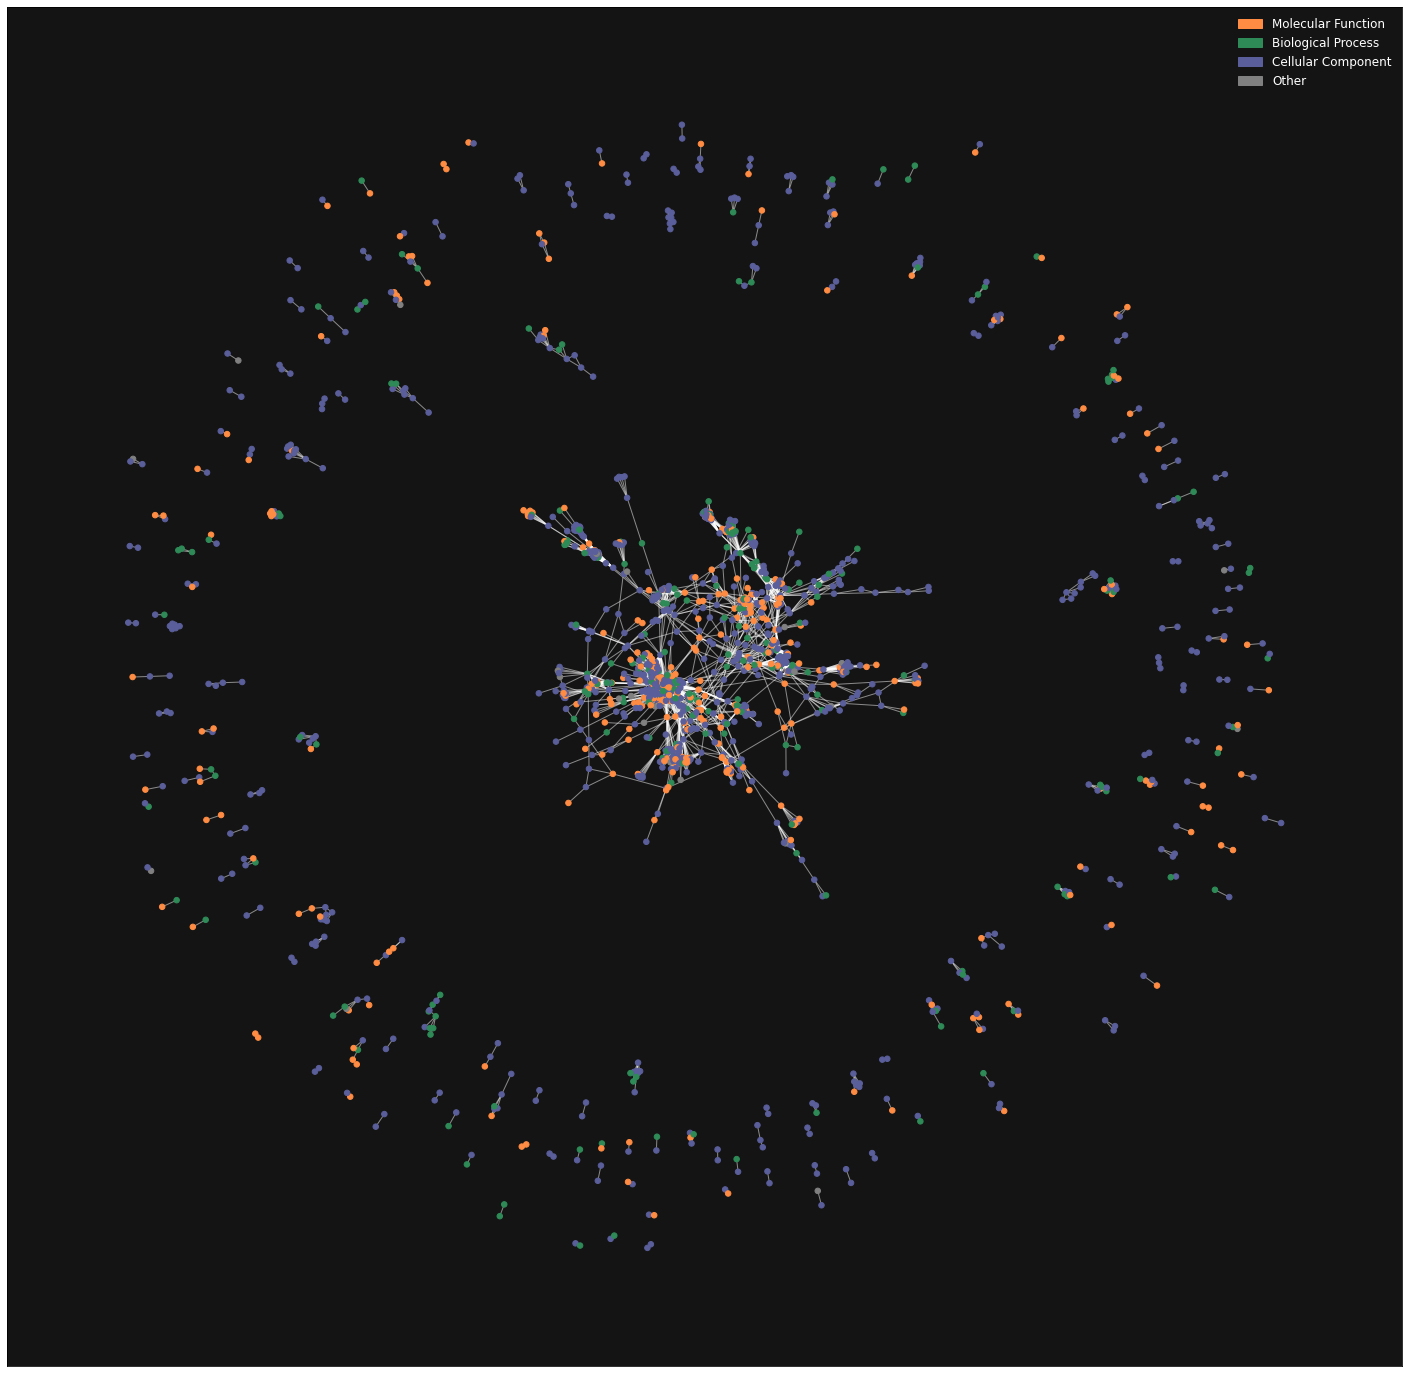

In [38]:
pos = nx.layout.fruchterman_reingold_layout(G)

fig, ax = plot_graph(G, color_map, pos)

legend_handles = [
	mpatches.Patch(color='#FF8C42', label='Molecular Function'),
	mpatches.Patch(color='seagreen', label='Biological Process'),
	mpatches.Patch(color='#5A5E9A', label='Cellular Component'),
	mpatches.Patch(color='gray', label='Other')
]

ax.legend(handles=legend_handles , loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

plt.show(fig)

In [ ]:
componentes_ordenados = sorted(nx.connected_components(G), key=len, reverse=True)
componente = componentes_ordenados[0]

subgraph = G.subgraph(componente)
color_map_subgraph = [color_map[list(G.nodes).index(node)] for node in subgraph.nodes]

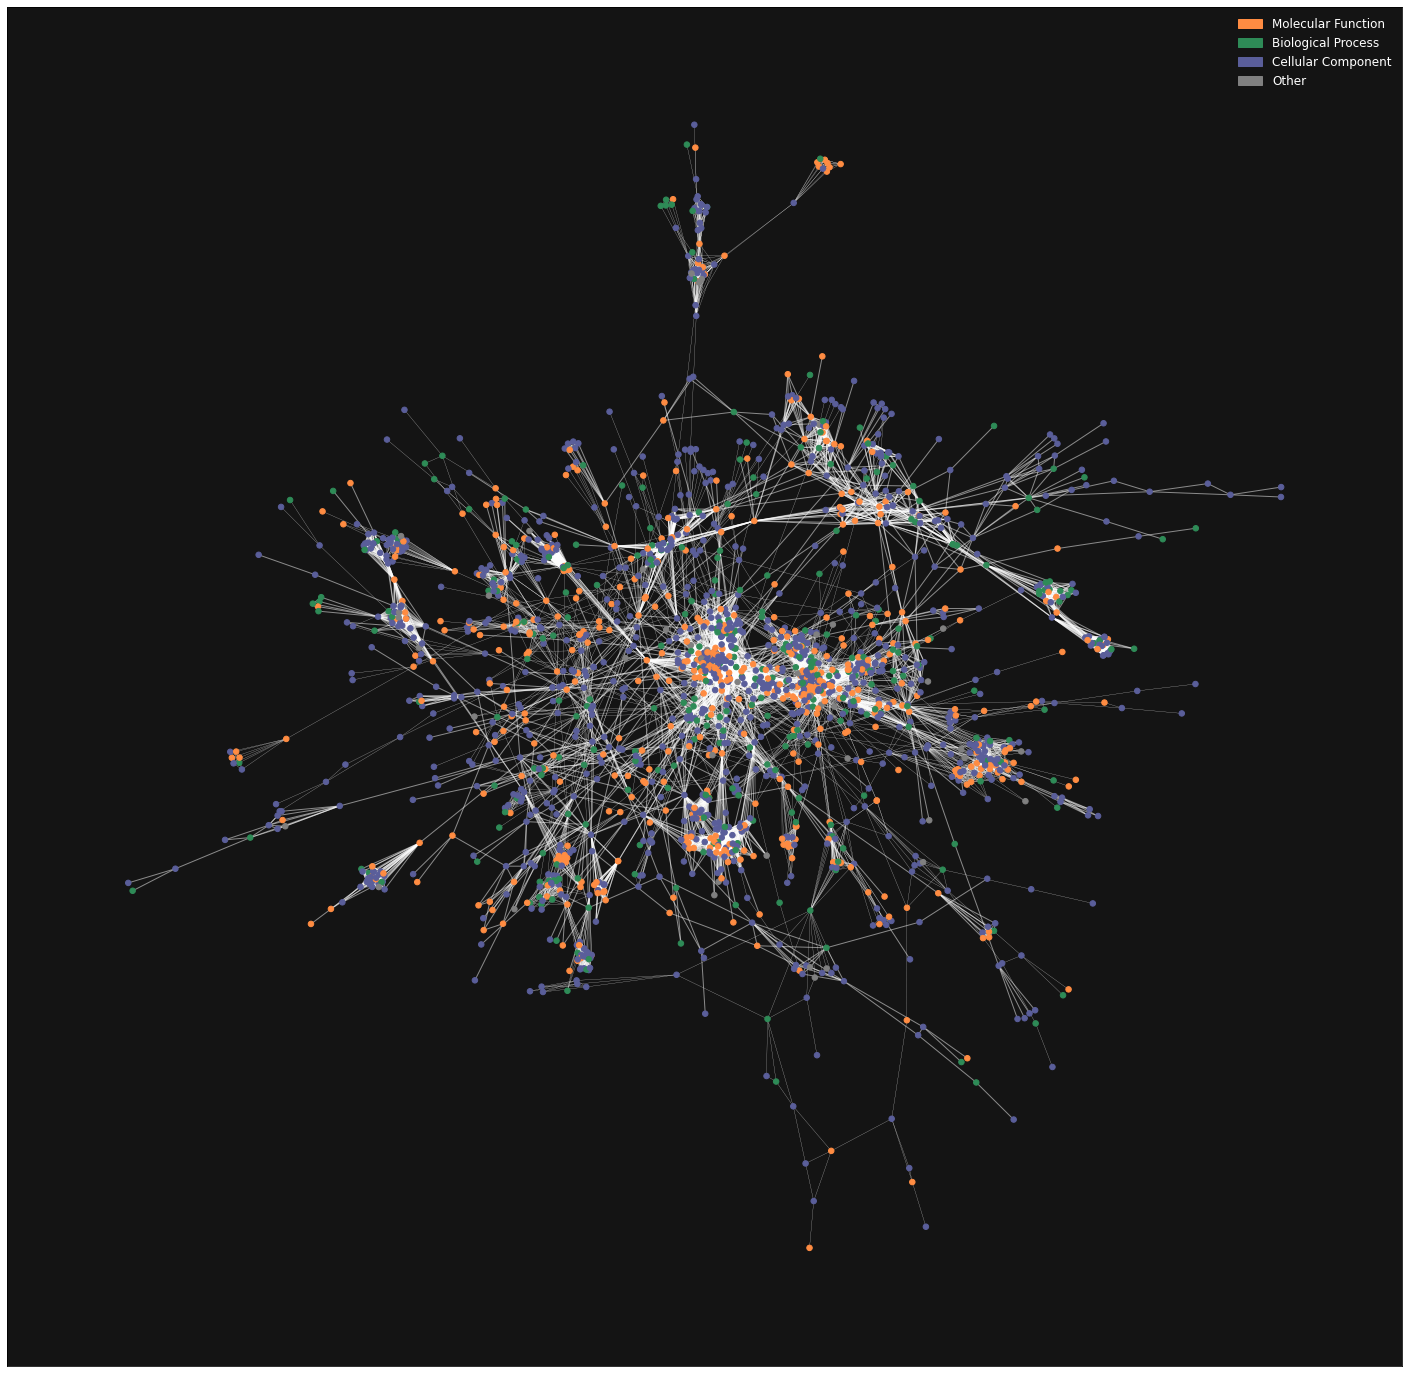

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (25, 25))

nx.draw_spring(subgraph, with_labels=False, node_color=color_map_subgraph, node_size=30, ax = ax, edge_color='white', width=0.2, font_size=10)

pos = nx.layout.fruchterman_reingold_layout(subgraph)

legend_handles = [mpatches.Patch(color='#FF8C42', label='Molecular Function'),
					mpatches.Patch(color='seagreen', label='Biological Process'),
					mpatches.Patch(color='#5A5E9A', label='Cellular Component'),
					mpatches.Patch(color='gray', label='Other')]

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(subgraph,
						   pos = pos,
						   node_color = color_map_subgraph,
						   ax = ax,
						   node_size = 30)
	
	nx.draw_networkx_edges(subgraph, pos = pos, ax = ax, alpha = .5, edge_color = 'white')
	ax.axis('on')

	ax.legend(handles=legend_handles , loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

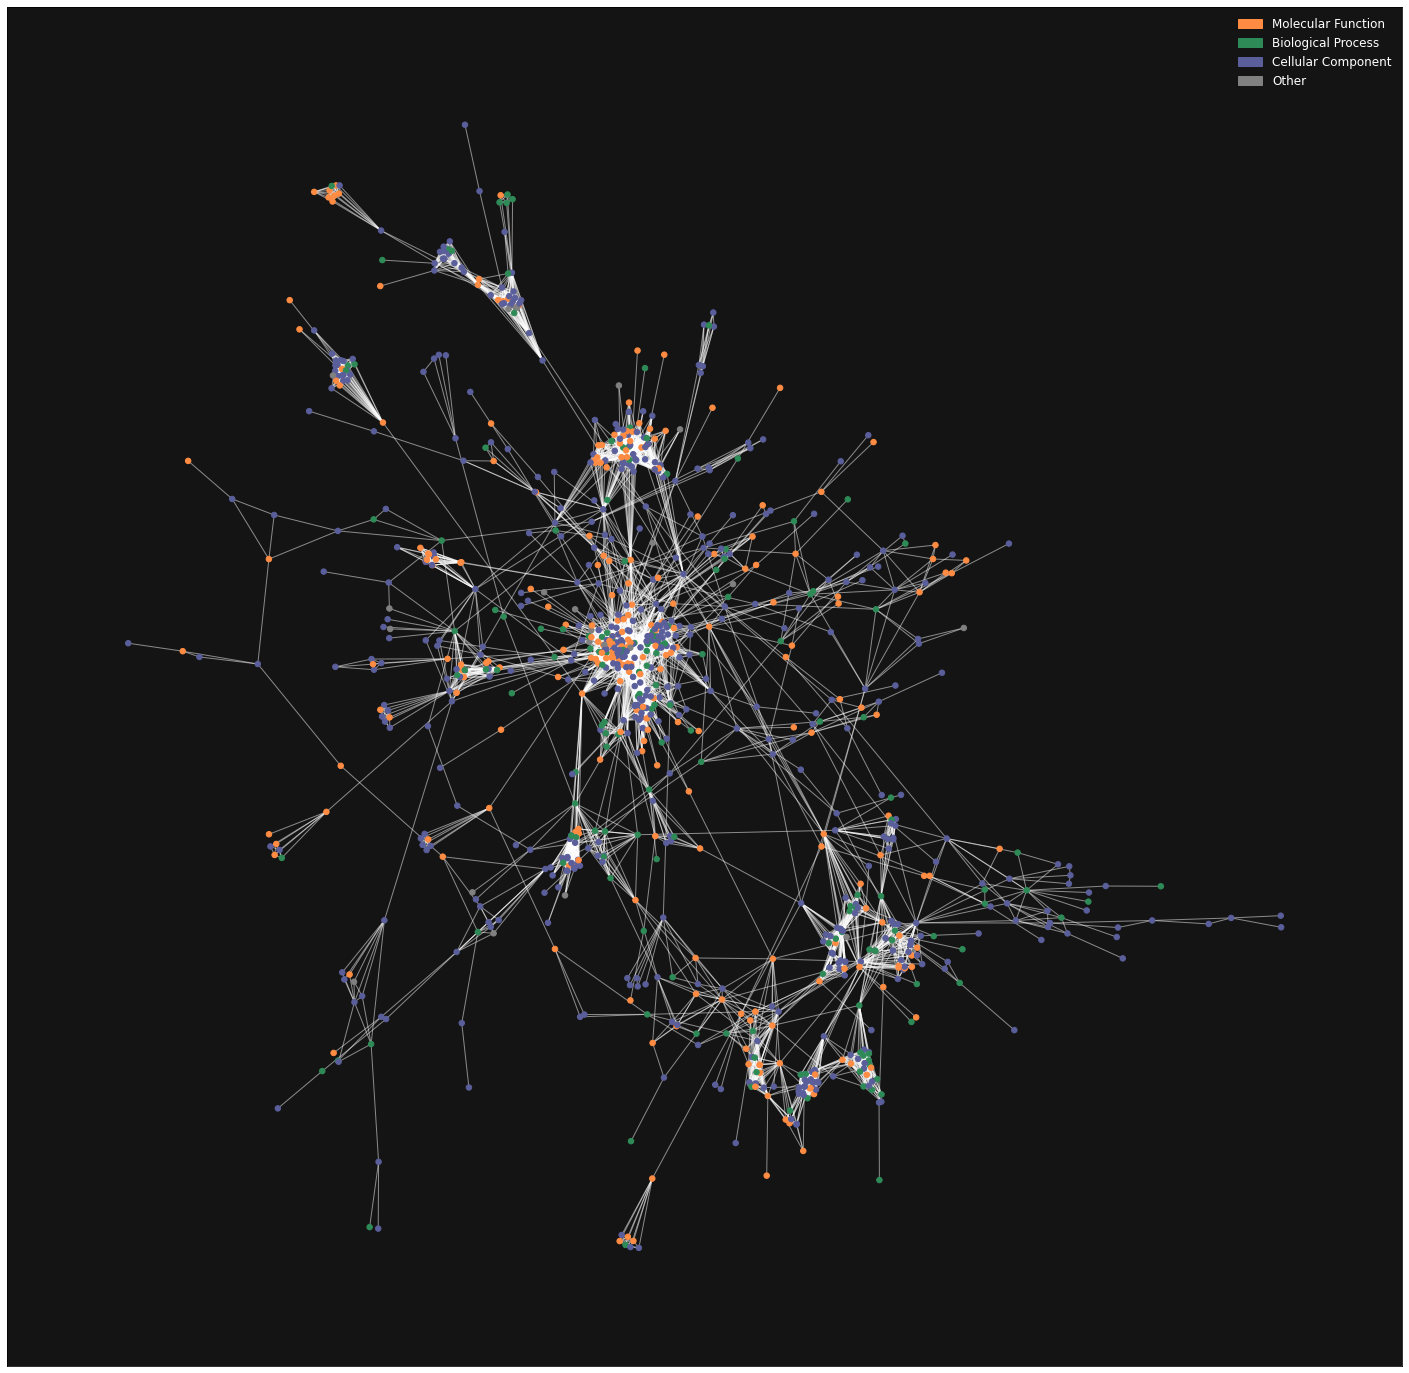

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (25, 25))

pos = nx.layout.fruchterman_reingold_layout(subgraph)

legend_handles = [mpatches.Patch(color='#FF8C42', label='Molecular Function'),
					mpatches.Patch(color='seagreen', label='Biological Process'),
					mpatches.Patch(color='#5A5E9A', label='Cellular Component'),
					mpatches.Patch(color='gray', label='Other')]

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(subgraph,
						   pos = pos,
						   node_color = color_map_subgraph,
						   ax = ax,
						   node_size = 30)
	
	nx.draw_networkx_edges(subgraph, pos = pos, ax = ax, alpha = .5, edge_color = 'white')
	ax.axis('on')

	ax.legend(handles=legend_handles , loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

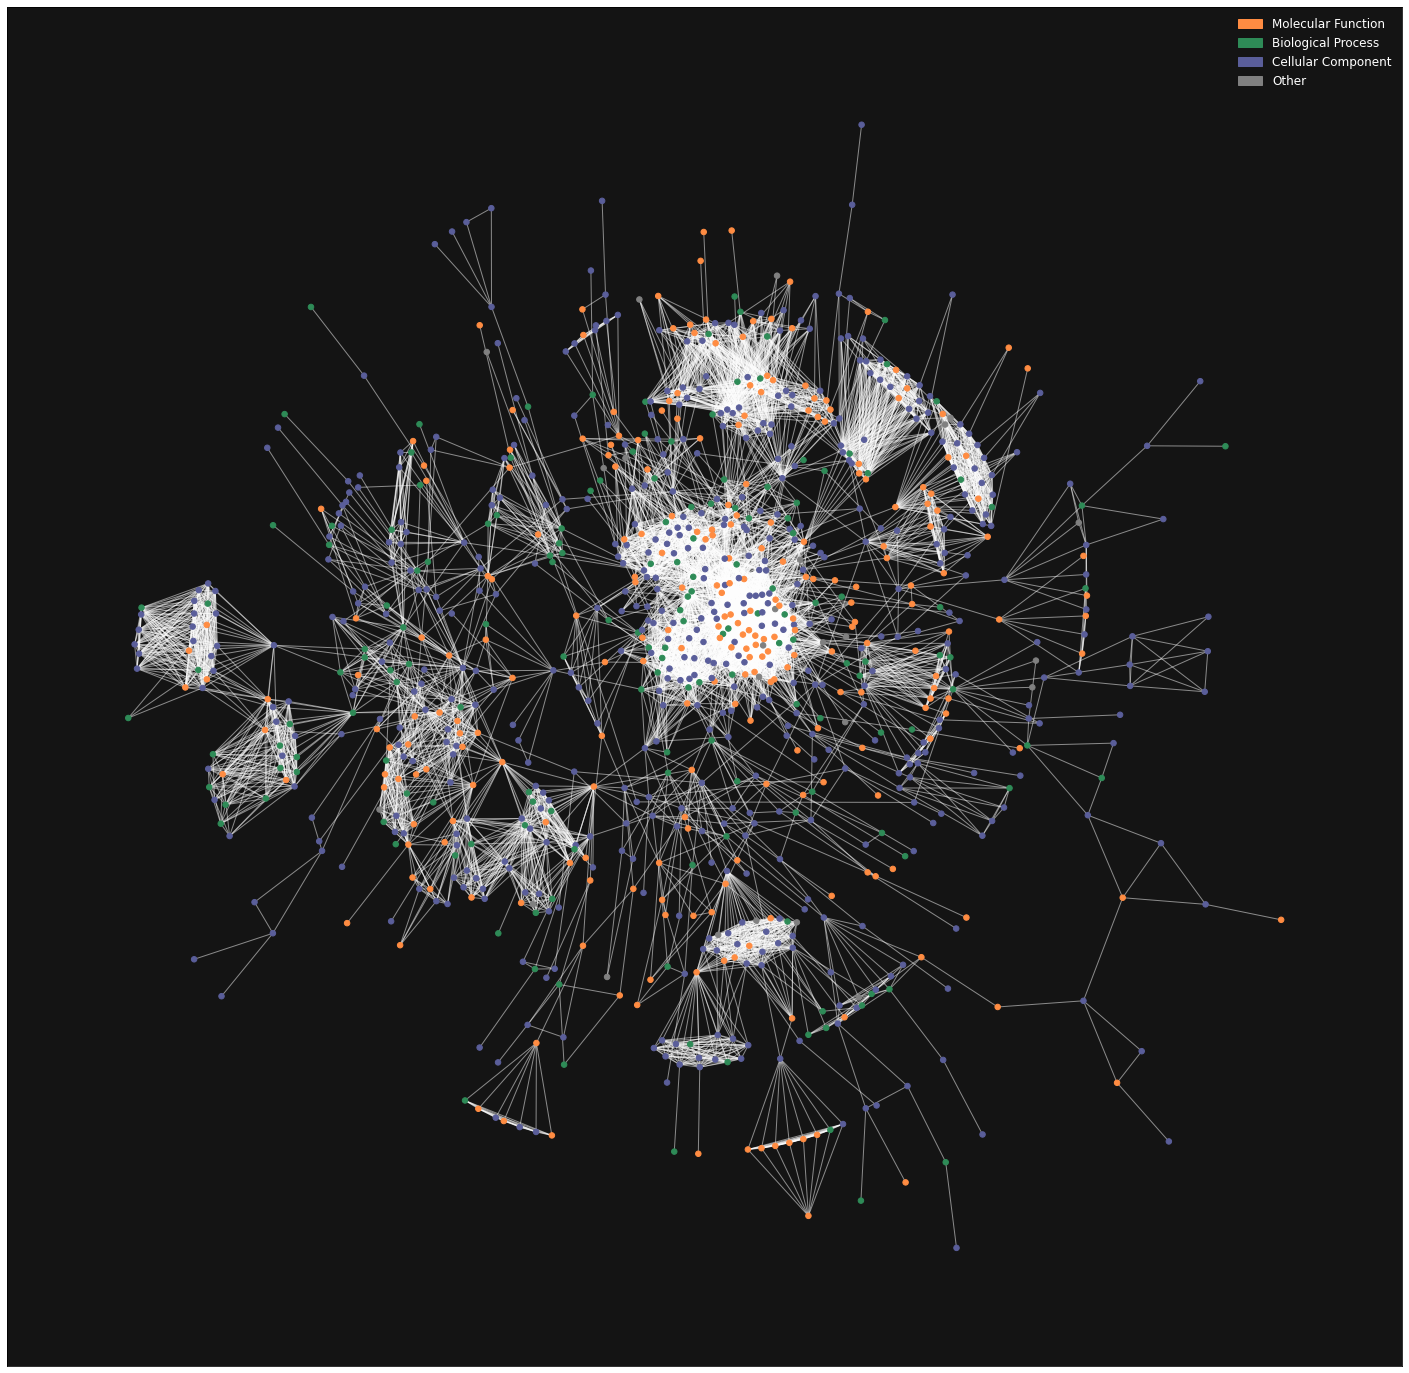

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (25, 25))

pos = nx.layout.kamada_kawai_layout(subgraph)
# fruchterman_reingold_layout(subgraph)

legend_handles = [mpatches.Patch(color='#FF8C42', label='Molecular Function'),
					mpatches.Patch(color='seagreen', label='Biological Process'),
					mpatches.Patch(color='#5A5E9A', label='Cellular Component'),
					mpatches.Patch(color='gray', label='Other')]

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(subgraph,
						   pos = pos,
						   node_color = color_map_subgraph,
						   ax = ax,
						   node_size = 30)
	
	nx.draw_networkx_edges(subgraph, pos = pos, ax = ax, alpha = .5, edge_color = 'white')
	ax.axis('on')

	ax.legend(handles=legend_handles , loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

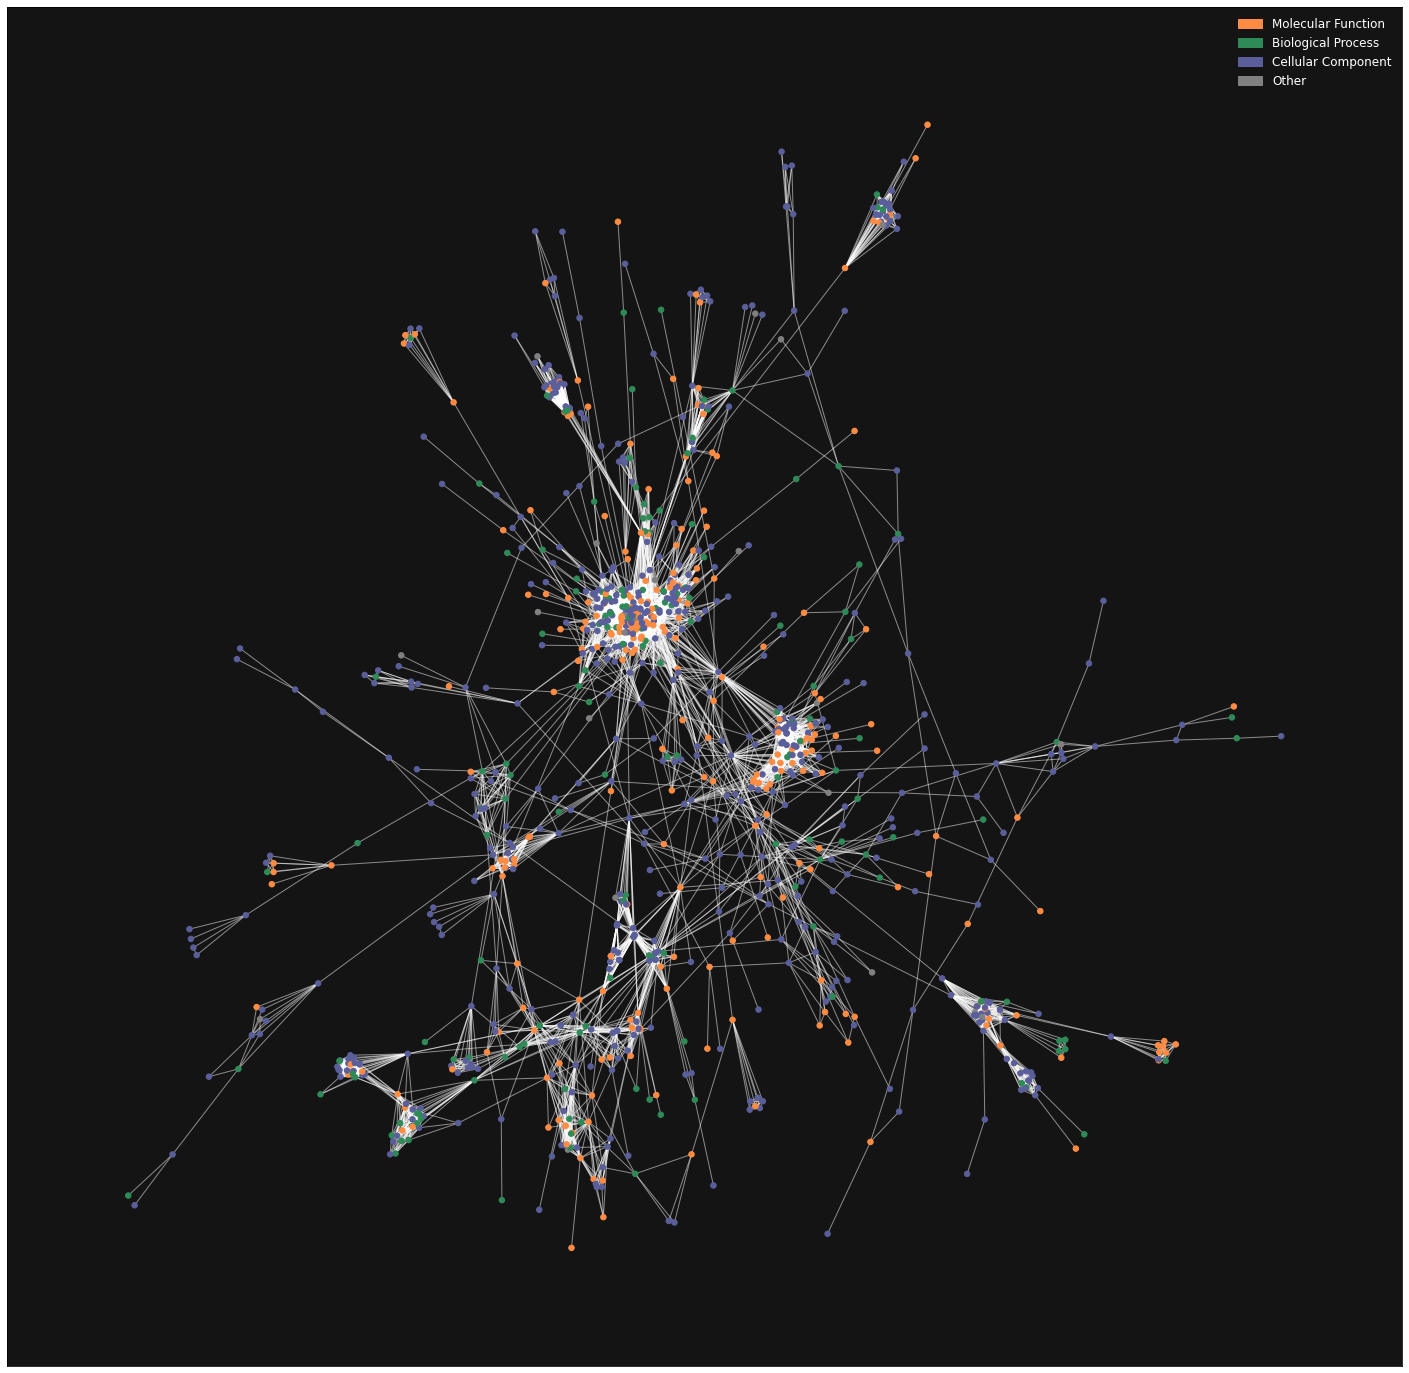

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (25, 25))

pos = nx.layout.spring_layout(subgraph)

legend_handles = [mpatches.Patch(color='#FF8C42', label='Molecular Function'),
					mpatches.Patch(color='seagreen', label='Biological Process'),
					mpatches.Patch(color='#5A5E9A', label='Cellular Component'),
					mpatches.Patch(color='gray', label='Other')]

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(subgraph,
						   pos = pos,
						   node_color = color_map_subgraph,
						   ax = ax,
						   node_size = 30)
	
	nx.draw_networkx_edges(subgraph, pos = pos, ax = ax, alpha = .5, edge_color = 'white')
	ax.axis('on')

	ax.legend(handles=legend_handles , loc='upper right', frameon=False, fontsize=12, labelcolor='white', markerscale=0.01)

-------------------
## Pruebas previas y fracasos 

In [9]:
knowledge_graph = nx.DiGraph()

In [10]:
for frame in pato:
    if isinstance(frame, fastobo.term.TermFrame):
        knowledge_graph.add_node(str(frame.id))
        for clause in frame:
            if isinstance(clause, fastobo.term.IsAClause):
                knowledge_graph.add_edge(str(frame.id), str(clause.term))

In [12]:
nx.is_directed_acyclic_graph(knowledge_graph)

True

In [15]:
superclass_nodes = nx.descendants(knowledge_graph, "GO:1901174")
superclass_nodes.add("GO:1901174")
super_graph = knowledge_graph.subgraph(superclass_nodes)

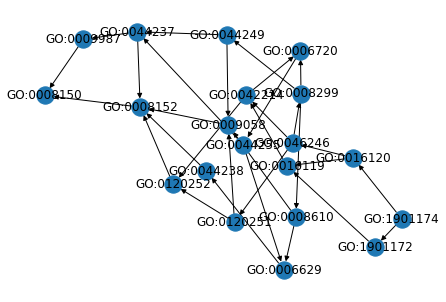

In [18]:
from networkx.drawing.nx_agraph import graphviz_layout

nx.draw(super_graph, with_labels=True, arrows=True)

In [27]:
knowledge_graph.number_of_nodes()

47904

In [2]:
df_datos = pd.read_json('Datos/go_yeast.json', orient='index')
df_datos.head()

0
graphs  {'id': 'http://purl.obolibrary.org/obo/go/subs...

In [3]:
import json

In [ ]:
# Cargar el archivo JSON
with open('Datos/go_yeast.json') as f:
    data = json.load(f)

In [5]:
print(data['graphs'][0].keys())

dict_keys(['id', 'meta', 'nodes', 'edges', 'logicalDefinitionAxioms', 'propertyChainAxioms'])


In [6]:
data['graphs'][0]['edges'][:3] #Entiendo que es cada elemento de la lista de enlaces un diccionario de "fulanito ES O HACE ALGO de mengano"

[{'sub': 'http://purl.obolibrary.org/obo/GO_0000054',
  'pred': 'is_a',
  'obj': 'http://purl.obolibrary.org/obo/GO_0051169'},
 {'sub': 'http://purl.obolibrary.org/obo/GO_0000278',
  'pred': 'is_a',
  'obj': 'http://purl.obolibrary.org/obo/GO_0008150'},
 {'sub': 'http://purl.obolibrary.org/obo/GO_0000278',
  'pred': 'http://purl.obolibrary.org/obo/BFO_0000051',
  'obj': 'http://purl.obolibrary.org/obo/GO_0048285'}]

In [ ]:
data['graphs'][0]['nodes'][:5] #Creo que cada nodo es una acción o descripción de algo "forma parte, procede de, ocurre en" y tienen un numero de id asignado



[{'id': 'http://purl.obolibrary.org/obo/BFO_0000050',
  'lbl': 'part of',
  'type': 'PROPERTY',
  'meta': {'xrefs': [{'val': 'BFO:0000050'}],
   'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
     'val': 'external'},
    {'pred': 'http://www.geneontology.org/formats/oboInOwl#shorthand',
     'val': 'part_of'}]}},
 {'id': 'http://purl.obolibrary.org/obo/BFO_0000051',
  'lbl': 'has part',
  'type': 'PROPERTY',
  'meta': {'xrefs': [{'val': 'BFO:0000051'}],
   'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
     'val': 'external'},
    {'pred': 'http://www.geneontology.org/formats/oboInOwl#shorthand',
     'val': 'has_part'}]}},
 {'id': 'http://purl.obolibrary.org/obo/BFO_0000062',
  'lbl': 'preceded by',
  'meta': {'xrefs': [{'val': 'BFO:0000062'}],
   'basicPropertyValues': [{'pred': 'http://www.geneontology.org/formats/oboInOwl#hasOBONamespace',
     'val': 'external'},
    {'pred': 'http:

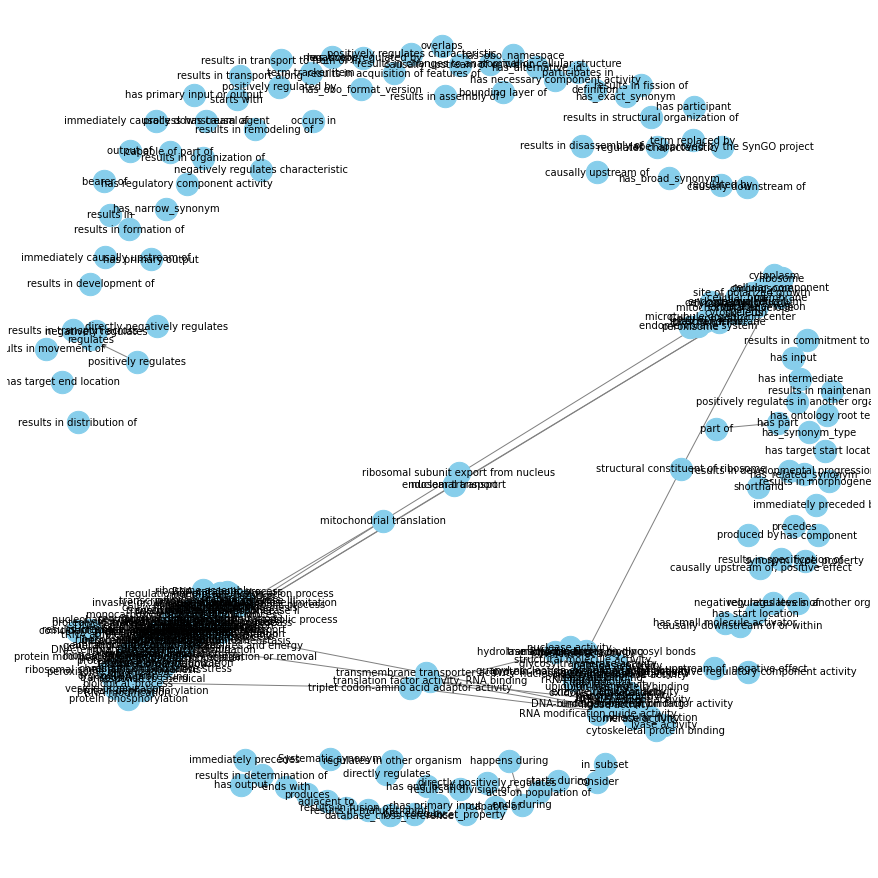

In [ ]:
G = nx.DiGraph()

# Iterar a través de los gráficos en graphs
for graph in data["graphs"]:
    # Agregar nodos al grafo
    for node in graph.get("nodes", []):
        node_id = node["id"]
        node_label = node.get("lbl", "")
        G.add_node(node_id, label=node_label, type=node.get("type"))
    
    # Agregar aristas (relaciones) al grafo si existen
    for edge in graph.get("edges", []):
        source = edge["sub"]
        target = edge["obj"]
        relation_type = edge.get("pred", "")
        G.add_edge(source, target, relation=relation_type)

# Visualizar el grafo (opcional)
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=500, font_size=10, node_color="skyblue", edge_color="gray", labels=nx.get_node_attributes(G, 'label'))
plt.show()

In [65]:
from collections import deque

In [66]:
# Crear un diccionario para almacenar el nivel de cada nodo
levels = {}

# Encuentra el nodo raíz (nodo sin predecesores)
root_nodes = [n for n, d in G.in_degree() if d == 0]

# Si hay varios nodos raíz, procesarlos por separado
for root in root_nodes:
    # Usar una cola para el recorrido BFS
    queue = deque([(root, 0)])  # (nodo, nivel)

    while queue:
        node, level = queue.popleft()
        
        # Si ya se ha calculado el nivel del nodo, continuamos
        if node in levels:
            continue
        
        # Almacenar el nivel del nodo
        levels[node] = level

        # Agregar los vecinos con un nivel aumentado en 1
        for neighbor in G.successors(node):
            queue.append((neighbor, level + 1))

# Verificar los niveles de cada nodo
for node, level in levels.items():
    print(f"Nodo: {node}, Nivel: {level}")

Nodo: http://purl.obolibrary.org/obo/BFO_0000050, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/BFO_0000051, Nivel: 1
Nodo: http://purl.obolibrary.org/obo/BFO_0000062, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/BFO_0000063, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/BFO_0000066, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GOREL_0000040, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GOREL_0001019, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GOREL_0002003, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GOREL_0002004, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GOREL_0012006, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GO_0000054, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GO_0051169, Nivel: 1
Nodo: http://purl.obolibrary.org/obo/GO_0008150, Nivel: 2
Nodo: http://purl.obolibrary.org/obo/GO_0005575, Nivel: 2
Nodo: http://purl.obolibrary.org/obo/GO_0000278, Nivel: 0
Nodo: http://purl.obolibrary.org/obo/GO_0048285, Nivel: 1
Nodo: http://purl.obolibrary.org/obo/GO_0000747, Niv

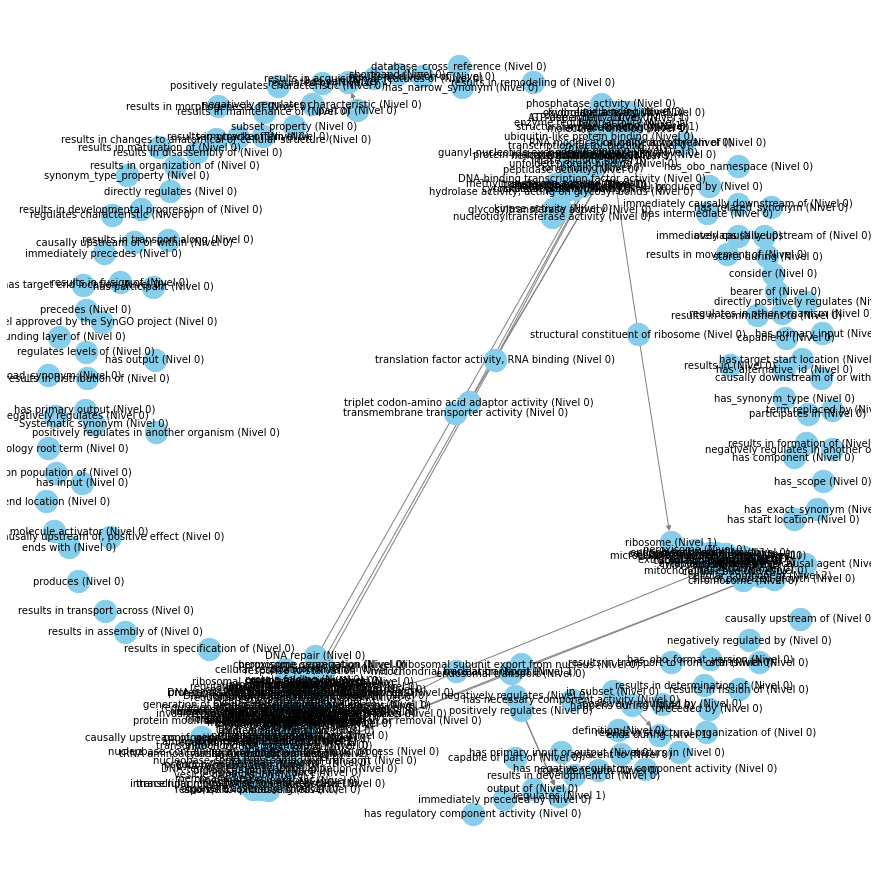

In [71]:
# Asignar niveles a los nodos para visualización
node_labels = {node: f"{data['label']} (Nivel {levels[node]})" for node, data in G.nodes(data=True)}

# Dibujar el grafo
plt.figure(figsize=(12, 12))
nx.draw(G, labels=node_labels, with_labels=True, node_size=500, font_size=10, node_color="skyblue", edge_color="gray")
plt.show()

In [9]:
# Cargar el archivo GAF descargado (aquí usamos el de SGD como ejemplo)
gaf_df = pd.read_csv('Datos/gene_association.sgd.20241028.gaf', sep='\t', comment='!', header=None)

# Extraer sólo las columnas de proteína y término GO
gaf_df = gaf_df[[1, 4]]
gaf_df.columns = ['protein_id', 'go_term_id']

# Ver los datos filtrados de proteínas y términos GO
print(gaf_df.head())

   protein_id  go_term_id
0  S000003381  GO:0090640
1  S000005701  GO:0090640
2  S000003381  GO:0036151
3  S000004492  GO:0033617
4  S000004977  GO:0052845


C:\Users\arell\AppData\Local\Temp\ipykernel_12460\2829194585.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  gaf_df = pd.read_csv('Datos/gene_association.sgd.20241028.gaf', sep='\t', comment='!', header=None)


In [12]:
gaf_df = pd.read_csv('Datos/gene_association.sgd.20241028.gaf', sep='\t', comment='!', header=None)
gaf_df

C:\Users\arell\AppData\Local\Temp\ipykernel_12460\1799236254.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  gaf_df = pd.read_csv('Datos/gene_association.sgd.20241028.gaf', sep='\t', comment='!', header=None)


0           1        2                           3           4   \
0       SGD  S000003381     GPC1  acts_upstream_of_or_within  GO:0090640   
1       SGD  S000005701     ALE1  acts_upstream_of_or_within  GO:0090640   
2       SGD  S000003381     GPC1  acts_upstream_of_or_within  GO:0036151   
3       SGD  S000004492     RCF1  acts_upstream_of_or_within  GO:0033617   
4       SGD  S000004977    SIW14                     enables  GO:0052845   
...     ...         ...      ...                         ...         ...   
206943  SGD  S000006502    SNR42                  located_in  GO:0005730   
206944  SGD  S000007313    SNR79                  located_in  GO:0005730   
206945  SGD  S000007300    SNR36                  located_in  GO:0005730   
206946  SGD  S000006484  RDN25-1                  located_in  GO:0005840   
206947  SGD  S000006485  RDN25-2                  located_in  GO:0005840   

                   5    6               7  8   \
0       PMID:30514764  IGI  SGD:S000005701  P   
1       PMID:30514764  IGI  SGD:S000003381  P   
2       PMID:30514764  IMP             NaN  P   
3       PMID:29746825  IMP             NaN  P   
4       PMID:26828065  IDA             NaN  F   
...               ...  ...             ... ..   
206943  PMID:30502926  IEA    Rfam:RF01265  C   
206944  PMID:30502926  IEA    Rfam:RF01184  C   
206945  PMID:30502926  IEA    Rfam:RF01242  C   
206946  PMID:30502926  IEA    Rfam:RF02543  C   
206947  PMID:30502926  IEA    Rfam:RF02543  C   

                                                       9   \
0           Glycerophosphocholine acyltransferase (GPCAT)   
1       Broad-specificity lysophospholipid acyltransfe...   
2           Glycerophosphocholine acyltransferase (GPCAT)   
3                            Cytochrome c oxidase subunit   
4       Inositol phosphatase involved in inositol pyro...   
...                                                   ...   
206943             H/ACA box small nucleolar RNA (snoRNA)   
206944               C/D box small nucleolar RNA (snoRNA)   
206945             H/ACA box small nucleolar RNA (snoRNA)   
206946                       25S ribosomal RNA (25S rRNA)   
206947                       25S ribosomal RNA (25S rRNA)   

                                                       10       11  \
0           YGR149W|glycerophosphocholine acyltransferase  protein   
1       YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein   
2           YGR149W|glycerophosphocholine acyltransferase  protein   
3                                           YML030W|AIM31  protein   
4       YNL032W|OCA3|putative tyrosine protein phospha...  protein   
...                                                   ...      ...   
206943                                    YNCK0020C|snR42   snoRNA   
206944                                 YNCL0005C|Z9|snR79   snoRNA   
206945                                    YNCO0022C|snR36   snoRNA   
206946         YNCL0012C|25S ribosomal RNA|26S rRNA|RDN25     rRNA   
206947         YNCL0021C|25S ribosomal RNA|26S rRNA|RDN25     rRNA   

                  12        13          14                   15  \
0       taxon:559292  20181220         SGD                  NaN   
1       taxon:559292  20181220         SGD                  NaN   
2       taxon:559292  20181220         SGD                  NaN   
3       taxon:559292  20181212         SGD                  NaN   
4       taxon:559292  20190110         SGD  part_of(GO:0071543)   
...              ...       ...         ...                  ...   
206943  taxon:559292  20241014  RNAcentral                  NaN   
206944  taxon:559292  20241014  RNAcentral                  NaN   
206945  taxon:559292  20241014  RNAcentral                  NaN   
206946  taxon:559292  20241014  RNAcentral                  NaN   
206947  taxon:559292  20241014  RNAcentral                  NaN   

                      16  
0       UniProtKB:P48236  
1       UniProtKB:Q08548  
2       UniProtKB:P48236  
3       UniProtKB:Q0

In [ ]:
#1 es codigo de proteina en levadura, 4 es el termino GO, 10 nombre que me interesa(hasta el |)

In [13]:
gaf_df[4]

0         GO:0090640
1         GO:0090640
2         GO:0036151
3         GO:0033617
4         GO:0052845
             ...    
206943    GO:0005730
206944    GO:0005730
206945    GO:0005730
206946    GO:0005840
206947    GO:0005840
Name: 4, Length: 206948, dtype: object